# Agrupamiento de imágenes con mapas autoorganizados

*Por Ernesto Ignacio Borbón Martínez, Luis Felipe Villaseñor Navarrete, José de Jesús Gutiérrez Aldrete y Gerardo Villegas Contreras*

En el blog anterior exploramos algo de la clasificación de imágenes con modelos tradicionales y redes neuronales. En esta entrada, nos enfocaremos en una nueva tarea: agrupar las imágenes, y para ello utilizaremos mapas autoorganizados. 

Los datos que agruparemos serán dos viejos conocidos: el conjunto de datos Fashion de MNIST, y el conjunto Emojis, que se describen en la sección de abajo.

La base de datos Emojis y todo el código de este blog pueden ser encontrados en https://github.com/ShoyChoy/agrupamiento-imagenes.git


## Las bases de datos

Fashion-MNIST consiste de 70,000 imágenes (60,000 de entrenamiento y 10,000 de prueba) de 10 diferentes prendas de vestir en escala de grises con un tamaño de 28x28, acompañado de sus etiquetas. Sus clases son:

* 0 T-shirt/top-Playera 
* 1 Trouser-Pantalón
* 2 Pullover-Suéter
* 3 Dress-Vestido
* 4 Coat-Abrigo
* 5 Sandal-Sandalia
* 6 Shirt-Camisa
* 7 Sneaker-Tenis
* 8 Bag-Bolsos
* 9 Ankle boot-Calzado alto

El segundo conjunto de datos consiste en 2470 imágenes binarias de emojis dibujados a mano con un tamaño de 32x32. Los diferentes emojis en la base de datos son caritas enojadas (clase 1) felices (2), tristes (4), sorprendidas (5) y el emoji de popó (clase 3). 


## Procedimientos preliminares

La implementación de mapa autoorganizado que usaremos será la de MiniSOM:

In [ ]:
pip install minisom

  Created wheel for minisom: filename=MiniSom-2.2.9-py3-none-any.whl size=8594 sha256=6270b0be470728c6ad8352ec7317c8b1bd6d7bf00c55a081524d9b782be993d2
  Stored in directory: /root/.cache/pip/wheels/3d/a1/10/f50b6f4865652eac239a2700de411c3078c27e1318320e494c
Successfully built minisom


Importación de librerías:

In [ ]:
from minisom import MiniSom
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from tensorflow import keras
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Carga de los datos:

In [ ]:
fashion_mnist = keras.datasets.fashion_mnist
(fashion_tr_im,fashion_tr_lab),(fashion_test_im,fashion_test_lab) = fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


In [ ]:
fashion_tr_im_rz = []
fashion_test_im_rz = []
for i in range(fashion_tr_im.shape[0]):
  fashion_tr_im_rz.append(fashion_tr_im[i].reshape(784))
for i in range(fashion_test_im.shape[0]):
  fashion_test_im_rz.append(fashion_test_im[i].reshape(784))

In [ ]:
ultra_fashion = fashion_tr_im_rz + fashion_test_im_rz
fashion_lab = list(fashion_tr_lab) + list(fashion_test_lab)

In [ ]:
emojis = np.loadtxt("/content/drive/MyDrive/Equipo TC2035/emojis.txt") 
x_emojis = emojis[:,1:]
y_emojis = emojis[:,0]

## Fashion

Con la base de datos de Fashion se hicieron dos pruebas, una con todos los datos (70,000) y la otra con los datos de prueba (10,000). Para ambos modelos se empleó una sigma de 4, una tasa de aprendizaje de 0.5 y la función de vecindario (neighborhood function) de triángulo, los modelos se usaron con 5000 épocas y se usó una malla de 50X50, con una entrada de 784 pixeles.

In [ ]:
som = MiniSom(50, 50, 784, sigma=4,
              learning_rate=0.5, neighborhood_function='triangle')
som.pca_weights_init(ultra_fashion)
som.train(ultra_fashion, 5000, random_order=True, verbose=True)  # random training

 [ 5000 / 5000 ] 100% - 0:00:00 left 

/usr/local/lib/python3.7/dist-packages/minisom.py:486: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(-2 * cross_term + input_data_sq + weights_flat_sq.T)



 quantization error: 2893.8466848470803


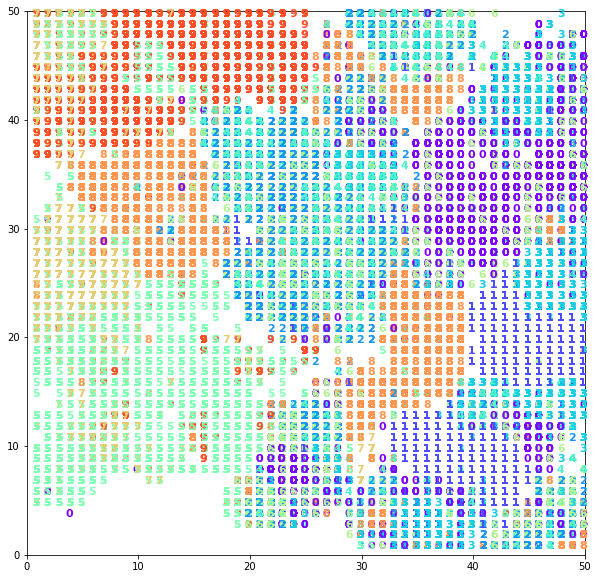

In [ ]:
plt.figure(figsize=(10, 10))
wmap = {}
im = 0
for x, t in zip(ultra_fashion, fashion_lab):  # scatterplot
    w = som.winner(x)
    wmap[w] = im
    plt. text(w[0]+.5,  w[1]+.5,  str(t),
              color=plt.cm.rainbow(t / 10.), fontdict={'weight': 'bold',  'size': 11})
    im = im + 1
plt.axis([0, som.get_weights().shape[0], 0,  som.get_weights().shape[1]])
plt.show()

Como se ve en la imagen anterior, hay zonas con varias clases sobrepuestas. Con el fin de mejorar la visualización y la interpretabilidad, se optó por revisar un segundo modelo con menos datos.

In [ ]:
som = MiniSom(50, 50, 784, sigma=4,
              learning_rate=0.5, neighborhood_function='triangle')
som.pca_weights_init(fashion_test_im_rz)
som.train(fashion_test_im_rz, 5000, random_order=True, verbose=True)  # random training

 [ 5000 / 5000 ] 100% - 0:00:00 left 
 quantization error: 2363.108724528113


/usr/local/lib/python3.7/dist-packages/minisom.py:486: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(-2 * cross_term + input_data_sq + weights_flat_sq.T)


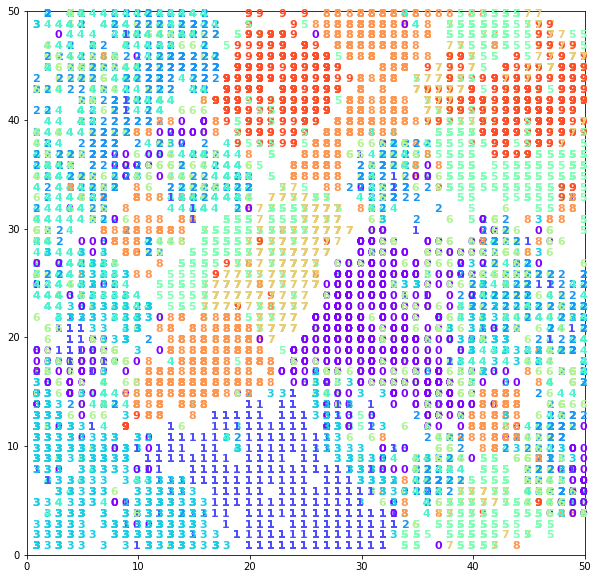

In [ ]:
plt.figure(figsize=(10, 10))
wmap = {}
im = 0
for x, t in zip(fashion_test_im_rz, fashion_test_lab):  # scatterplot
    w = som.winner(x)
    wmap[w] = im
    plt. text(w[0]+.5,  w[1]+.5,  str(t),
              color=plt.cm.rainbow(t / 10.), fontdict={'weight': 'bold',  'size': 11})
    im = im + 1
plt.axis([0, som.get_weights().shape[0], 0,  som.get_weights().shape[1]])
plt.show()

## Emojis

Para el conjunto de datos de los emojis también se crearon dos mapas autoorganizados, ambos con un sigma de 4, tasa de aprendizaje de 0.5, función de vecindario (neighborhood function) de triángulo y de entrada se usaron los 1024 pixeles de cada imagen. Lo que diferencia a ambos modelos es el tamaño de la malla, donde el primer modelo tuvo una malla de 70x70 mientras que el segundo tuvo una malla de 50x50.


In [ ]:
som = MiniSom(70, 70, 1024, sigma=4,
              learning_rate=0.5, neighborhood_function='triangle')
som.pca_weights_init(x_emojis)
som.train(x_emojis, 5000, random_order=True, verbose=True)  # random training

 [ 5000 / 5000 ] 100% - 0:00:00 left 
 quantization error: 5.775293136441469


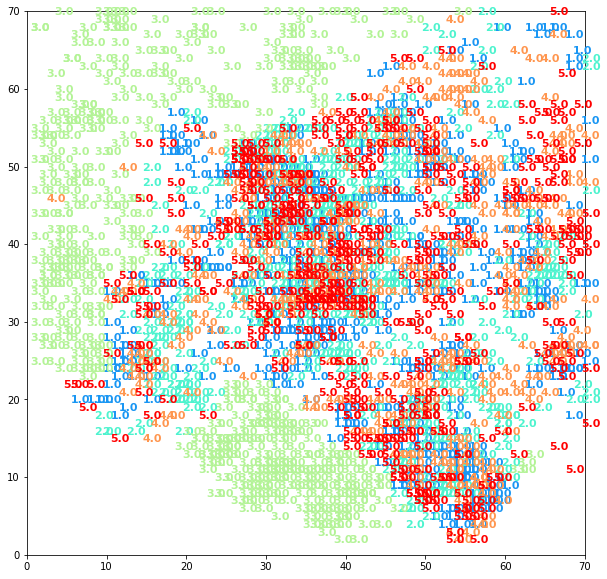

In [ ]:
plt.figure(figsize=(10, 10))
wmap = {}
im = 0
for x, t in zip(x_emojis, y_emojis):  # scatterplot
    w = som.winner(x)
    wmap[w] = im
    plt. text(w[0]+.5,  w[1]+.5,  str(t),
              color=plt.cm.rainbow(t / 5.), fontdict={'weight': 'bold',  'size': 11})
    im = im + 1
plt.axis([0, som.get_weights().shape[0], 0,  som.get_weights().shape[1]])
plt.show()

Observando esta figura de arriba, es entendible por qué redujimos el tamaño de la malla. Por un lado, por la cantidad de zonas en blanco (no toda la malla se "aprovechó"), y por el otro, porque sería más sencillo de visualizar.

In [ ]:
som = MiniSom(50, 50, 1024, sigma=4,
              learning_rate=0.5, neighborhood_function='triangle')
som.pca_weights_init(x_emojis)
som.train(x_emojis, 5000, random_order=True, verbose=True)  # random training

 [ 5000 / 5000 ] 100% - 0:00:00 left 
 quantization error: 7.035020744858327


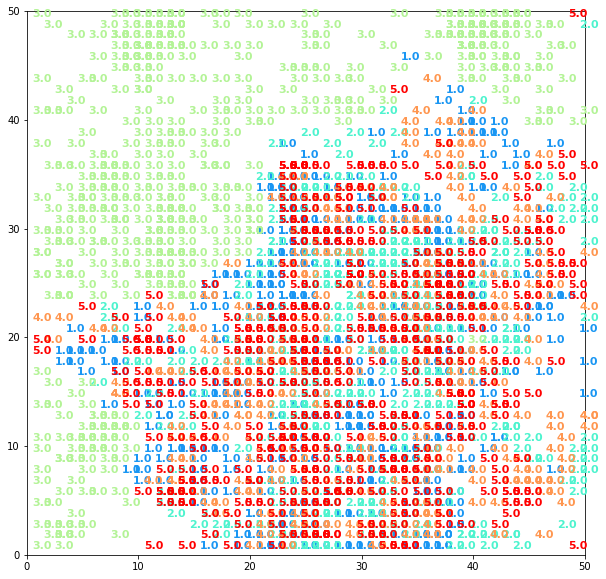

In [ ]:
plt.figure(figsize=(10, 10))
wmap = {}
im = 0
for x, t in zip(x_emojis, y_emojis):  # scatterplot
    w = som.winner(x)
    wmap[w] = im
    plt. text(w[0]+.5,  w[1]+.5,  str(t),
              color=plt.cm.rainbow(t / 5.), fontdict={'weight': 'bold',  'size': 11})
    im = im + 1
plt.axis([0, som.get_weights().shape[0], 0,  som.get_weights().shape[1]])
plt.show()

## Resultados


Para el primer mapa autoorganizado del conjunto de datos Fashion se utilizaron todos los datos (70,000) y se obtuvo un error de cuantificación de 2893.84.

También se realizó otro mapa autoorganizado utilizando solo el conjunto de prueba de Fashion con 10,000 datos y se obtuvo un error de cuantificación de 2363.11.

En ambos casos podemos observar que hay un grupo bien definido de la clase 1 (pantalones) y está al lado de un grupo de la clase 3 (vestidos). También podemos observar que hay un grupo grande de clase 0 (t-shirts y tops) mezclado con imágenes de clase 6 (camisas). Finalmente, hay muchos casos en donde se empalman imágenes de clase 5, 7 y 9 (sandalias, tenis y calzado alto).

El mapa autoorganizado del conjunto de datos emojis con la malla de 70x70 obtuvo un error de cuantificación de 5.77 y el de la malla de 50x50 obtuvo un error de cuantificación de 7.04.
En los mapas autoorganizado de los emojis también podemos observar resultados muy similares. La única clase con grupos verdaderamente diferenciados es la clase 3 (el emoji de popó). El resto de las clases forman un grupo en donde se empalman todas. Curiosamente, en ambos mapas se formaron dos grupos bien definidos de la clase 3, separados por algunas imágenes de clase 1 (caritas enojadas) y 5 (caritas sorprendidas).
